In [2]:
# Load packages
library(mgcv)
library(ggplot2)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(grid)
library(writexl)
library(magrittr)
library(rstatix)

Loading required package: nlme

This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

Warning message:
"package 'ggplot2' was built under R version 4.2.0"
Warning message:
"package 'tidyverse' was built under R version 4.2.0"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
v purrr   0.3.4     

Warning message:
"package 'stringr' was built under R version 4.2.0"
Warning message:
"package 'forcats' was built under R version 4.2.0"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::collapse() masks nlme::collapse()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


W

In [18]:
PATH <- file.path("C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project") #"/home/andewegs/1_RSV_scripts/"
setwd(PATH)
incidence <- read_csv(file = "Flu_incidence.csv")

Rows: 19 Columns: 3
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl (3): day, children, adults

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [19]:
incidence

day,children,adults
<dbl>,<dbl>,<dbl>
1,35,50
2,40,70
3,30,117
4,1395,467
5,3000,1096
6,7064,2734
7,9382,5021
8,7583,5501
9,3760,2753


In [20]:
dt <- 0.25
sir_data <- mcstate::particle_filter_data(data = incidence,
                                          time = "day",
                                          rate = 1 / dt)
rmarkdown::paged_table(sir_data)

day_start,day_end,step_start,step_end,children,adults
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,0,4,35,50
1,2,4,8,40,70
2,3,8,12,30,117
3,4,12,16,1395,467
4,5,16,20,3000,1096
5,6,20,24,7064,2734
6,7,24,28,9382,5021
7,8,28,32,7583,5501
8,9,32,36,3760,2753


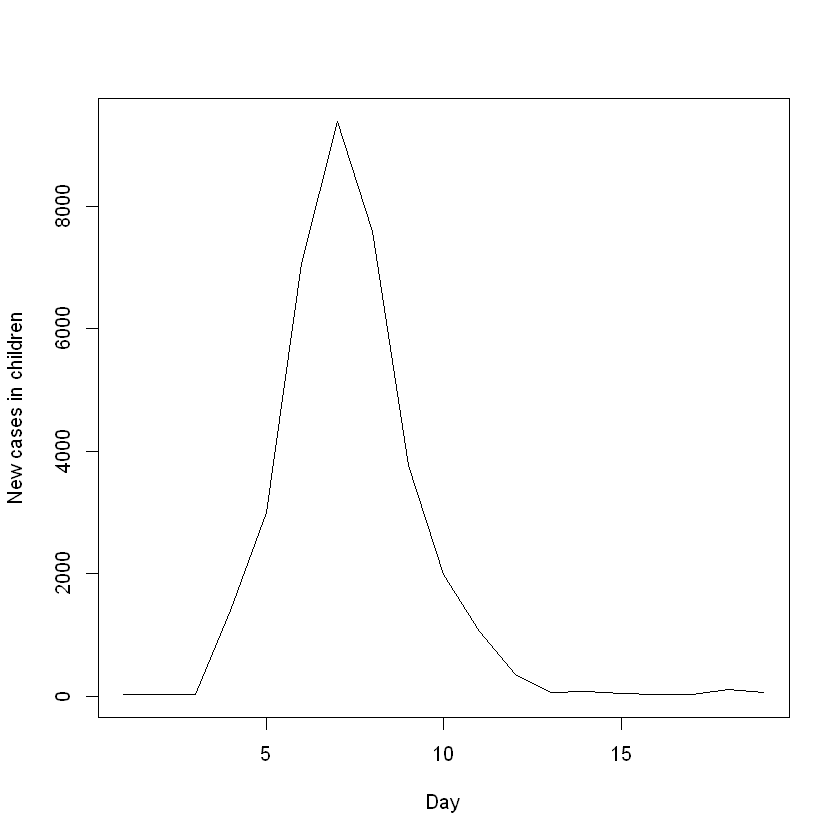

In [22]:
plot(incidence$day, incidence$children,
     type = "l", xlab = "Day", ylab = "New cases in children")

In [31]:
case_compare <- function(state, observed, pars = NULL) {
  exp_noise <- 1e6

  incidence_modelled <- state[5, , drop = TRUE]
  incidence_observed <- observed$children
  lambda <- incidence_modelled +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = incidence_observed, lambda = lambda, log = TRUE)
}

In [25]:
gen_sir <- dust::dust_example("sir")
gen_sir$new(pars = list(), step = 0, n_particles = 1L)$info()

$vars
[1] "S"           "I"           "R"           "cases_cumul" "cases_inc"  

$pars
$pars$beta
[1] 0.2

$pars$gamma
[1] 0.1

In [32]:
incidence_compare <- function(state, prev_state, observed, pars = NULL) {
  exp_noise <- 1e6

  lambda <- state[4, , drop = TRUE] +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = observed$children, lambda = lambda, log = TRUE)
}

In [33]:
n_particles <- 100
filter <- mcstate::particle_filter$new(data = sir_data,
                                       model = gen_sir,
                                       n_particles = n_particles,
                                       compare = case_compare,
                                       seed = 1L)

In [34]:
filter$run(save_history = TRUE, pars = list(dt = dt))

[1] -152252.1

ERROR: Error in t(true_history[1:3, , -1]): object 'true_history' not found


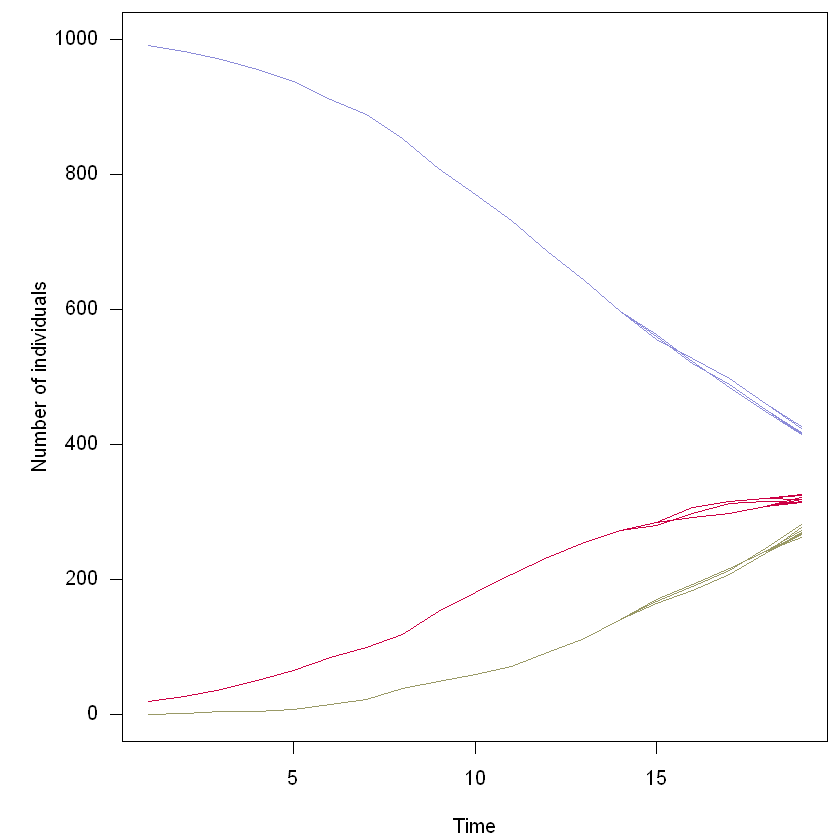

In [35]:
plot_particle_filter <- function(history, true_history, times, obs_end = NULL) {
  if (is.null(obs_end)) {
    obs_end <- max(times)
  }

  par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
  cols <- c(S = "#8c8cd9", I = "#cc0044", R = "#999966")
  matplot(times, t(history[1, , -1]), type = "l",
          xlab = "Time", ylab = "Number of individuals",
          col = cols[["S"]], lty = 1, ylim = range(history))
  matlines(times, t(history[2, , -1]), col = cols[["I"]], lty = 1)
  matlines(times, t(history[3, , -1]), col = cols[["R"]], lty = 1)
  matpoints(times[1:obs_end], t(true_history[1:3, , -1]), pch = 19,
            col = cols)
  legend("left", lwd = 1, col = cols, legend = names(cols), bty = "n")
}

#true_history <- readRDS("sir_true_history.rds")
plot_particle_filter(filter$history(), true_history, incidence$day)

In [36]:
filter$run(save_history = TRUE, pars = list(dt = dt, beta = 0.4, gamma = 0.2))

[1] -124077.1

**Inferring parameters**

In [37]:
beta <- mcstate::pmcmc_parameter("beta", 0.2, min = 0)
gamma <- mcstate::pmcmc_parameter("gamma", 0.1, min = 0, prior = function(p)
  dgamma(p, shape = 1, scale = 0.2, log = TRUE))

proposal_matrix <- diag(0.1, 2)
mcmc_pars <- mcstate::pmcmc_parameters$new(list(beta = beta, gamma = gamma),
                                           proposal_matrix)

In [40]:
n_steps <- 500
n_burnin <- 200
control <- mcstate::pmcmc_control(
    n_steps,
    save_state = TRUE,
    save_trajectories = TRUE,
    progress = TRUE)
pmcmc_run <- mcstate::pmcmc(mcmc_pars, filter, control = control)

Running chain 1 / 1


Step 14 / 500 [>-----------------------------------] ETA  8s | 00:00:00 so far

Step 15 / 500 [>-----------------------------------] ETA  9s | 00:00:00 so far

Step 16 / 500 [>-----------------------------------] ETA  9s | 00:00:00 so far

Step 17 / 500 [>-----------------------------------] ETA 10s | 00:00:00 so far

Step 18 / 500 [>-----------------------------------] ETA 10s | 00:00:00 so far

Step 19 / 500 [>-----------------------------------] ETA 11s | 00:00:00 so far

Step 20 / 500 [>-----------------------------------] ETA 11s | 00:00:00 so far

Step 21 / 500 [=>----------------------------------] ETA 11s | 00:00:00 so far

Step 22 / 500 [=>----------------------------------] ETA 12s | 00:00:00 so far

Step 23 / 500 [=>----------------------------------] ETA 12s | 00:00:00 so far

Step 24 / 500 [=>----------------------------------] ETA 12s | 00:00:00 so far

Step 25 / 500 [=>----------------------------------] ETA 12s | 00:00:00 so far

Step 26 / 500 [=>-

In [41]:
processed_chains <- mcstate::pmcmc_thin(pmcmc_run, burnin = n_burnin, thin = 2)
parameter_mean_hpd <- apply(processed_chains$pars, 2, mean)
parameter_mean_hpd

beta     gamma 
0.7482551 0.1770996

**Tuning the MCMC**

In [43]:
proposal_matrix <- cov(pmcmc_run$pars)
mcmc_pars <- mcstate::pmcmc_parameters$new(
  list(beta = beta, gamma = gamma),
  proposal_matrix)
proposal_matrix

,beta,gamma
beta,0.003988641,0.002485005
gamma,0.002485005,0.001824264


In [44]:
control <- mcstate::pmcmc_control(
    n_steps,
    save_state = TRUE,
    save_trajectories = TRUE,
    progress = TRUE,
    n_chains = 4)
pmcmc_tuned_run <- mcstate::pmcmc(mcmc_pars, filter, control = control)

Running chain 1 / 4


Step 20 / 500 [>-----------------------------------] ETA  5s | 00:00:00 so far

Step 21 / 500 [=>----------------------------------] ETA  6s | 00:00:00 so far

Step 22 / 500 [=>----------------------------------] ETA  6s | 00:00:00 so far

Step 23 / 500 [=>----------------------------------] ETA  6s | 00:00:00 so far

Step 24 / 500 [=>----------------------------------] ETA  7s | 00:00:00 so far

Step 25 / 500 [=>----------------------------------] ETA  7s | 00:00:00 so far

Step 26 / 500 [=>----------------------------------] ETA  7s | 00:00:00 so far

Step 27 / 500 [=>----------------------------------] ETA  8s | 00:00:00 so far

Step 28 / 500 [=>----------------------------------] ETA  8s | 00:00:00 so far

Step 29 / 500 [=>----------------------------------] ETA  8s | 00:00:00 so far

Step 30 / 500 [=>----------------------------------] ETA  8s | 00:00:00 so far

Step 31 / 500 [=>----------------------------------] ETA  8s | 00:00:00 so far

Step 32 / 500 [=>-

In [46]:
install.packages('coda')

Installing package into 'C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/R/win-library/4.1'
(as 'lib' is unspecified)



package 'coda' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\julia\AppData\Local\Temp\RtmpIR1QDA\downloaded_packages


In [47]:
mcmc2 <- coda::as.mcmc(cbind(
  pmcmc_tuned_run$probabilities, pmcmc_tuned_run$pars))

summary(mcmc2)


Iterations = 1:2000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                     Mean        SD  Naive SE Time-series SE
log_prior      -9.917e-01    0.5007 1.120e-02        0.10275
log_likelihood -1.039e+05 5478.5393 1.225e+02      509.17062
log_posterior  -1.039e+05 5478.2722 1.225e+02      509.14169
beta            9.734e-01    0.1463 3.271e-03        0.02503
gamma           5.202e-01    0.1001 2.239e-03        0.02055

2. Quantiles for each variable:

                     2.5%        25%        50%        75%      97.5%
log_prior      -1.725e+00 -1.309e+00 -7.863e-01 -7.403e-01  2.034e-01
log_likelihood -1.146e+05 -1.031e+05 -1.029e+05 -1.026e+05 -1.026e+05
log_posterior  -1.146e+05 -1.031e+05 -1.029e+05 -1.026e+05 -1.026e+05
beta            5.160e-01  8.870e-01  9.837e-01  1.062e+00  1.109e+00
gamma           2.812e-01  4.700e-01  4.792e-01  5.836e-

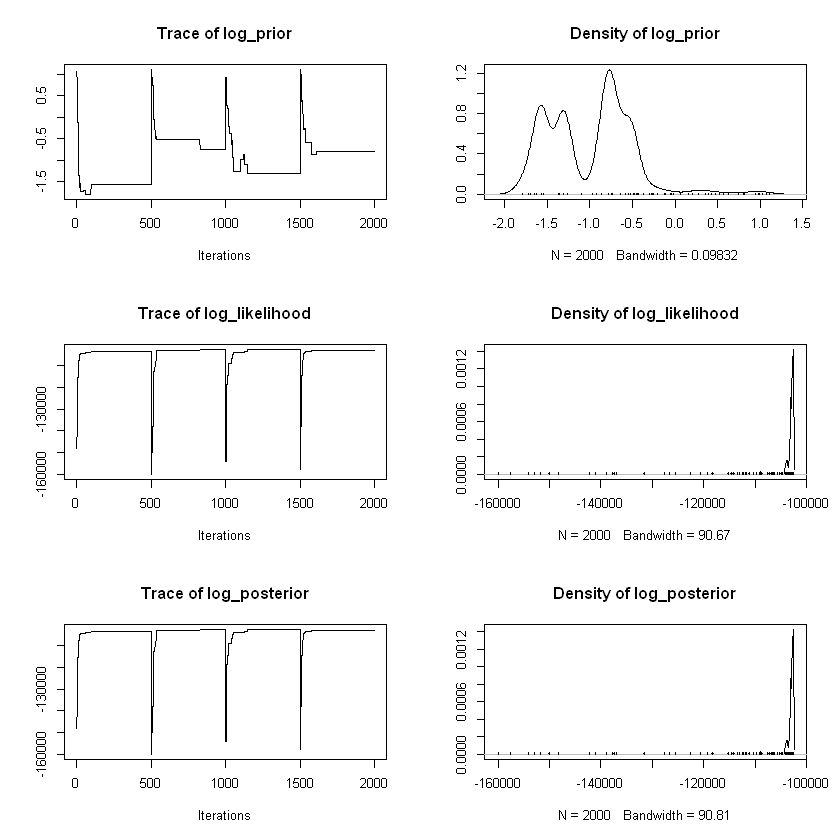

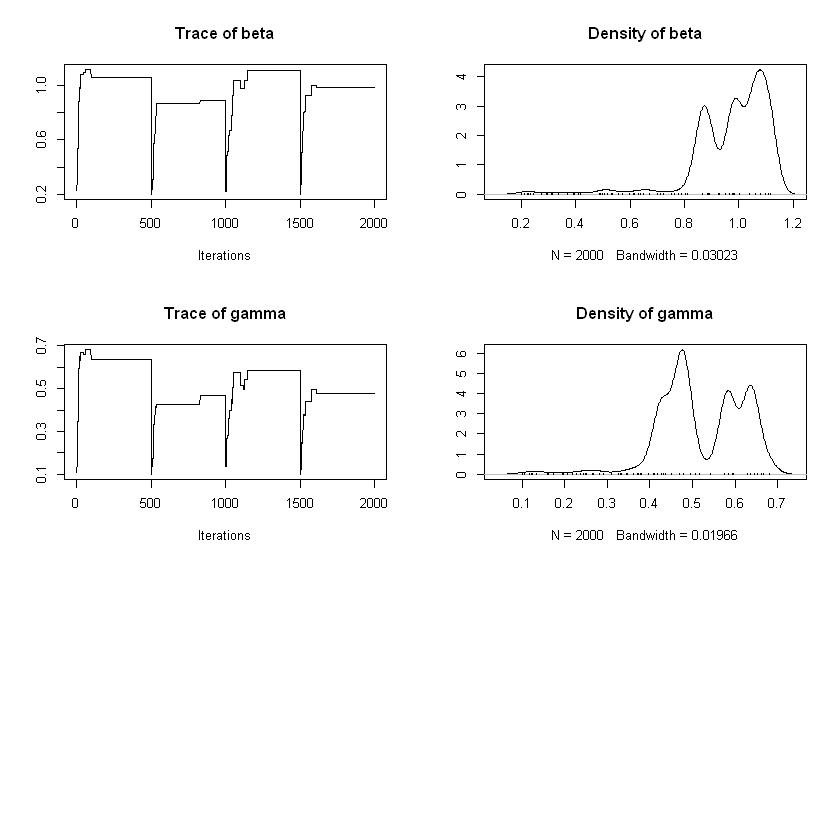

In [48]:
plot(mcmc2)

**Running predictions**

In [50]:
forecast <- predict(processed_chains,
                    steps = seq(400, 800, 4),
                    prepend_trajectories = TRUE,
                    seed = processed_chains$predict$seed)

keep <- sample.int(ncol(forecast$state), size = 10)
mini_forecast <- forecast$state[, keep, ]

plot_particle_filter(mini_forecast,
                     true_history,
                     seq_len(20),
                     obs_end = max(incidence$day))

ERROR: Error in pmcmc_predict(object, ...): Expected steps[1] to be 76
